# Imports

In [1]:
from matplotlib import image as mpimg
import tensorflow as tf
import torch
import os
import re
import requests
from PIL import Image
from torchvision.transforms import ToTensor
from tensorflow import keras
import matplotlib.pyplot as plt     # to plot charts
import numpy as np
import pandas as pd                 # for data manipulation
pd.set_option('display.max_colwidth', None)
import cv2                          # for image processing
from io import BytesIO
from tabulate import tabulate       # to print pretty tables
import seaborn as sns
import shutil

# sklearn imports for metrics and dataset splitting
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# keras imports for image preprocessing
from keras.preprocessing.image import ImageDataGenerator

# huggingface imports for model building 
import torch.nn as nn
from transformers import ViTModel, ViTForImageClassification, TrainingArguments, Trainer, \
  default_data_collator, EarlyStoppingCallback, ViTConfig, AutoImageProcessor, ViTImageProcessor 
from transformers.modeling_outputs import SequenceClassifierOutput

# keras imports for early stoppage and model checkpointing
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from datasets import load_dataset, load_metric, Features, ClassLabel, Array3D, Dataset
import datasets

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
DATASET_URL = 'https://data.lhncbc.nlm.nih.gov/public/Pills/'
directory = "dataset"
train_dir = "training20_set"
test_dir = "testing20_set"
img_height = 224
img_width = 224
batch_size = 64

# Import (Top 20)

In [3]:
# load the csv files
csv_file_top20 = "./top20.csv"
csv_file = "./table.csv"
csv_file2 = "./directory_consumer_grade_images.xlsx"
top20_df = pd.read_csv(csv_file_top20)
table_df = pd.read_csv(csv_file)
directory_df = pd.read_excel(csv_file2)

top20_list = top20_df['Name'].tolist()

In [4]:
# remove .wmv files
directory_df = directory_df[~directory_df['Image'].str.contains('.wmv', case=False, na=False)]

In [5]:
# Create a function to get the base label
def get_base_label(label):
    for item in top20_list:
        if item.lower() in label.lower():
            return item
    return label

In [6]:
# find the top 20 medications in the two datasets
# find matches in table_df
matches_in_table_df = pd.DataFrame()
for item in top20_list:
    item = item.upper()
    matches = table_df[table_df['name'].fillna('').str.contains(item, case=False, na=False) ]
    matches_in_table_df = pd.concat([matches_in_table_df, matches])

# find matches in directory_df
matches_in_directory_df = pd.DataFrame()
for item in top20_list:
    item = item.upper()
    matches = directory_df[directory_df['Name'].fillna('').str.contains(item, case=False, na=False) ]
    matches_in_directory_df = pd.concat([matches_in_directory_df, matches])

# generate the test set
test_df = matches_in_directory_df[matches_in_directory_df['Layout'] == 'C3PI_Test']

# keep only necessary images
matches_in_directory_df = matches_in_directory_df[matches_in_directory_df['Layout'].isin(['MC_API_NLMIMAGE_V1.3', 'MC_CHALLENGE_V1.0'])]

# remove unnecessary columns and rename columns
matches_in_table_df = matches_in_table_df[['name', 'nlmImageFileName']]
matches_in_table_df = matches_in_table_df.rename(columns={'name': 'labels', 'nlmImageFileName': 'image_paths'})
matches_in_directory_df = matches_in_directory_df[['Image', 'Name']]
matches_in_directory_df = matches_in_directory_df.rename(columns={'Image': 'image_paths', 'Name': 'labels'})
test_df = test_df[['Image', 'Name']]
test_df = test_df.rename(columns={'Image': 'image_paths', 'Name': 'labels'})

# # Remove .wmv files
# matches_in_table_df = matches_in_table_df[~matches_in_table_df['image_paths'].str.contains('.wmv', case=False, na=False, regex=True)]
# matches_in_directory_df = matches_in_directory_df[~matches_in_directory_df['image_paths'].str.contains('.wmv', case=False, na=False, regex=True)]

# add a base label column for the top 20 medications
matches_in_table_df['base_label'] = matches_in_table_df['labels'].apply(get_base_label)
matches_in_directory_df['base_label'] = matches_in_directory_df['labels'].apply(get_base_label)
test_df['base_label'] = test_df['labels'].apply(get_base_label)

# instantiate the label encoder
encoder = LabelEncoder()
encoder.fit(top20_list)

# Transform the data in the dataframes
matches_in_table_df['base_label'] = encoder.transform(matches_in_table_df['base_label'])
matches_in_directory_df['base_label'] = encoder.transform(matches_in_directory_df['base_label'])
test_df['base_label'] = encoder.transform(test_df['base_label'])

top20_instances_df = pd.concat([matches_in_table_df, matches_in_directory_df])

In [8]:
top20_instances_df.head()

,labels,image_paths,base_label
89,Acetaminophen 325 MG / butalbital 50 MG / Caffeine 40 MG / Codeine Phosphate 30 MG Oral Capsule,51991-0073-01_NLMIMAGE10_EE1FF71F.jpg,0
188,Acetaminophen 325 MG / butalbital 50 MG / Caffeine 40 MG / Codeine Phosphate 30 MG Oral Capsule,00591-3220-01_NLMIMAGE10_BE135F3A.jpg,0
268,Acetaminophen 650 MG / butalbital 50 MG Oral Capsule [Phrenilin],00187-0844-01_NLMIMAGE10_AF1C5782.jpg,0
322,Acetaminophen 500 MG / Caffeine 65 MG Oral Tablet,00363-0572-31_NLMIMAGE10_9038C876.jpg,0
559,Acetaminophen 500 MG / butalbital 50 MG / Caffeine 40 MG Oral Tablet,00603-2545-21_NLMIMAGE10_F223797B.jpg,0


In [9]:
print('training set size: ',top20_instances_df.size)
print('test set size: ',test_df.size)
print('number of unique labels: ',len(top20_instances_df['base_label'].unique()))

training set size:  4014
test set size:  12045
number of unique labels:  20


In [10]:
top20_instances_df.head()

,labels,image_paths,base_label
89,Acetaminophen 325 MG / butalbital 50 MG / Caffeine 40 MG / Codeine Phosphate 30 MG Oral Capsule,51991-0073-01_NLMIMAGE10_EE1FF71F.jpg,0
188,Acetaminophen 325 MG / butalbital 50 MG / Caffeine 40 MG / Codeine Phosphate 30 MG Oral Capsule,00591-3220-01_NLMIMAGE10_BE135F3A.jpg,0
268,Acetaminophen 650 MG / butalbital 50 MG Oral Capsule [Phrenilin],00187-0844-01_NLMIMAGE10_AF1C5782.jpg,0
322,Acetaminophen 500 MG / Caffeine 65 MG Oral Tablet,00363-0572-31_NLMIMAGE10_9038C876.jpg,0
559,Acetaminophen 500 MG / butalbital 50 MG / Caffeine 40 MG Oral Tablet,00603-2545-21_NLMIMAGE10_F223797B.jpg,0


In [11]:
test_df.head()

,image_paths,labels,base_label
36956,PillProjectDisc102/images/SW6WWOIZYS_-KGZ06H56GRM0LU2JL0.JPG,TRAMADOL HCl AND ACETAMINOPHEN,0
36957,PillProjectDisc104/images/V58T12T8IVQZSDEAGXJRFTOPOOVBTZ.JPG,TRAMADOL HCl AND ACETAMINOPHEN,0
36958,PillProjectDisc109/images/ZHA8Q0SLMEH0NLD1HUJAONPJTQOULI.JPG,TRAMADOL HCl AND ACETAMINOPHEN,0
36959,PillProjectDisc19/images/B3!JMH4I72GCEFGHS!H3S3YX29X!T!6.JPG,TRAMADOL HCl AND ACETAMINOPHEN,0
36960,PillProjectDisc31/images/BEUNKANGYL35POW6SZX0CPP6UTWNT-W.JPG,TRAMADOL HCl AND ACETAMINOPHEN,0


base_label
metformin          179
levothyroxine      153
acetaminophen      101
metoprolol          98
citalopram          96
atorvastatin        83
prednisone          83
fluoxetine          79
omeprazole          59
ciprofloxacin       50
sertraline          50
aspirin             49
alprazolam          45
ranitidine          40
ibuprofen           40
levofloxacin        39
cyclobenzaprine     38
loratadine          21
cetirizine          21
diphenhydramine     14
Name: count, dtype: int64


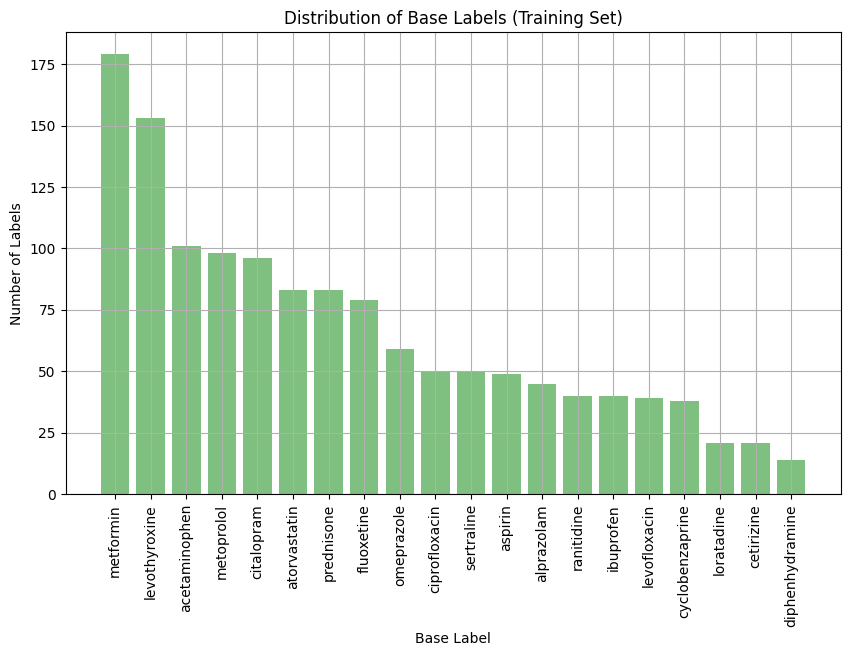

base_label
levothyroxine      703
metformin          497
citalopram         350
fluoxetine         322
metoprolol         284
prednisone         271
acetaminophen      244
sertraline         163
omeprazole         154
atorvastatin       151
ranitidine         131
alprazolam         130
cyclobenzaprine    128
aspirin            125
ciprofloxacin      115
ibuprofen          103
levofloxacin        86
cetirizine          34
loratadine          13
diphenhydramine     11
Name: count, dtype: int64


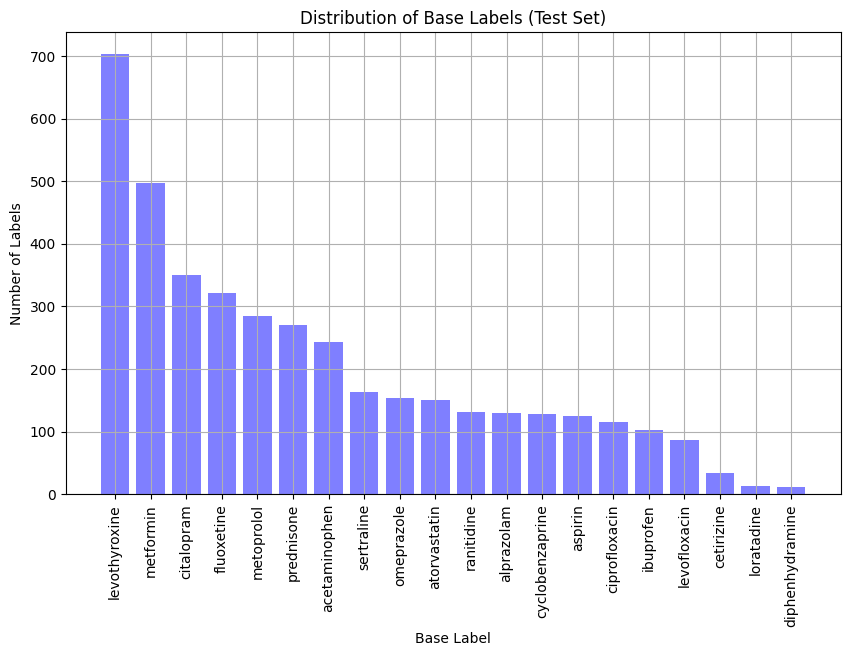

In [12]:
# Decode the labels in top20_instances_df
top20_instances_df['base_label'] = encoder.inverse_transform(top20_instances_df['base_label'])

# Check if the data is imbalanced in the training set
train_label_counts = top20_instances_df['base_label'].value_counts()
print(train_label_counts)

# Plot the label counts
plt.figure(figsize=(10,6))
plt.bar(train_label_counts.index, train_label_counts.values, alpha=0.5, color='g')
plt.title('Distribution of Base Labels (Training Set)')
plt.xlabel('Base Label')
plt.ylabel('Number of Labels')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Decode the labels in test_df
test_df['base_label'] = encoder.inverse_transform(test_df['base_label'])

# Check if the data is imbalanced in the test set
test_label_counts = test_df['base_label'].value_counts()
print(test_label_counts)

# Plot the label counts for the test set
plt.figure(figsize=(10,6))
plt.bar(test_label_counts.index, test_label_counts.values, alpha=0.5, color='b')
plt.title('Distribution of Base Labels (Test Set)')
plt.xlabel('Base Label')
plt.ylabel('Number of Labels')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [13]:
# Re-encode the labels
top20_instances_df['base_label'] = encoder.transform(top20_instances_df['base_label'])
test_df['base_label'] = encoder.transform(test_df['base_label'])

# Downloading the Training Data

In [14]:
website_url = 'https://data.lhncbc.nlm.nih.gov/public/Pills/'
dataset_dir = './dataset'
training_dir = './training20_set'

# Make sure the training directory exists
if not os.path.exists(training_dir):
    os.makedirs(training_dir)

# Function to download an image from a URL and save it to a directory
def download_image(url, save_path):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            response.raw.decode_content = True
            shutil.copyfileobj(response.raw, f)
        return True
    else:
        print(f"Failed to download image from {url}")
        return False

for index, row in top20_instances_df.iterrows():
    file_name = row['image_paths']
    save_path = os.path.join(training_dir, os.path.basename(file_name))
    if os.path.exists(os.path.join(dataset_dir, file_name)):
        shutil.copy(os.path.join(dataset_dir, file_name), save_path)
    elif not os.path.exists(save_path):  # Check if file already exists in the target directory
        url = website_url + file_name
        if download_image(url, save_path):
            print(f"Downloaded {file_name} from {url}")
        else:
            print(f"Failed to find {file_name} in dataset_dir and download from {url}")
    else:
        print(f"{file_name} already exists in {training_dir}, skipping download.")


PillProjectDisc21/images/B54F11M17ETU6I4Y4LD49S4QPIV_0XY.JPG already exists in ./training20_set, skipping download.
PillProjectDisc64/images/CH30G998!3L5!VQDP!GNHNH3QROQWF3.JPG already exists in ./training20_set, skipping download.
PillProjectDisc46/images/BSF-MYLWSBSE7045BCEQHTTXD9XQMFF.JPG already exists in ./training20_set, skipping download.
PillProjectDisc2/images/-HK6P72NWYPUY4-AZLFWGC0EBDLUCW.JPG already exists in ./training20_set, skipping download.
PillProjectDisc28/images/BC82I9X3SEE7EMA39-__RGBGCMWINN6.JPG already exists in ./training20_set, skipping download.
PillProjectDisc41/images/BO-CNSK9JA2FSDMDUTUI0MTMEOS4GP1.JPG already exists in ./training20_set, skipping download.
PillProjectDisc49/images/BV9TYQ-ASE5MPU2W96P22E-56K!Q4O4.JPG already exists in ./training20_set, skipping download.
PillProjectDisc97/images/OCPCTLLI0K5_H3Z2XETHJK2CY5FBJ6.JPG already exists in ./training20_set, skipping download.
PillProjectDisc40/images/BMYIY725YMS7OQRYSRQ52GU1P33-SWV.JPG already exists

# Downloading the Test Data

In [15]:
testing_dir = './testing20_set'

# Make sure the testing directory exists
if not os.path.exists(testing_dir):
    os.makedirs(testing_dir)

for index, row in test_df.iterrows():
    file_name = row['image_paths']
    
    # Check if the file ends with ".wmv", if so, skip it
    if file_name.endswith('.WMV'):
        print(f"Skipping {file_name} as it has the .wmv extension")
        continue
    
    save_path = os.path.join(testing_dir, os.path.basename(file_name))
    if os.path.exists(os.path.join(dataset_dir, file_name)):
        shutil.copy(os.path.join(dataset_dir, file_name), save_path)
    elif not os.path.exists(save_path):  # Check if file already exists in the target directory
        url = website_url + file_name
        if download_image(url, save_path):
            print(f"Downloaded {file_name} from {url}")
        else:
            print(f"Failed to find {file_name} in dataset_dir and download from {url}")
    else:
        print(f"{file_name} already exists in {testing_dir}, skipping download. It was downloaded previously.")


PillProjectDisc102/images/SW6WWOIZYS_-KGZ06H56GRM0LU2JL0.JPG already exists in ./testing20_set, skipping download. It was downloaded previously.
PillProjectDisc104/images/V58T12T8IVQZSDEAGXJRFTOPOOVBTZ.JPG already exists in ./testing20_set, skipping download. It was downloaded previously.
PillProjectDisc109/images/ZHA8Q0SLMEH0NLD1HUJAONPJTQOULI.JPG already exists in ./testing20_set, skipping download. It was downloaded previously.
PillProjectDisc19/images/B3!JMH4I72GCEFGHS!H3S3YX29X!T!6.JPG already exists in ./testing20_set, skipping download. It was downloaded previously.
PillProjectDisc31/images/BEUNKANGYL35POW6SZX0CPP6UTWNT-W.JPG already exists in ./testing20_set, skipping download. It was downloaded previously.
PillProjectDisc35/images/BIHBYXY772PDLOVK05!-NH-5MQ3YOUE.JPG already exists in ./testing20_set, skipping download. It was downloaded previously.
PillProjectDisc40/images/BMNIMZT5R29_!F2BABQ6NE43TA4UVFP.JPG already exists in ./testing20_set, skipping download. It was download

In [16]:
# print the size of the dataset
print('Number of files in the training set: ', len(os.listdir('./training20_set')))
print('Number of files in the test set: ', len(os.listdir('./testing20_set')))

Number of files in the training set:  1335
Number of files in the test set:  4018


# Helper Functions

In [17]:
# Function to convert an image file to a tensor
def image_to_tensor(image_file):
    image = Image.open(image_file)
    image = Resize((224, 224))(image)
    return ToTensor()(image)

#calculate the weights
def get_weight(class_num, label_count):
    weights = 1 / np.log(label_count)
    weights = class_num * weights/np.sum(weights)
    return weights

def add_class_weights(input_data):
    #get the number of labels
    result_data = input_data
    label_num = len(result_data['labels'].unique())
    
    #Create a Pandas dataframe for weight caculation
    value = result_data.value_counts('labels').tolist()
    value_df = pd.DataFrame({'labels': result_data.value_counts('labels').index.tolist(), 'counts':result_data.value_counts('labels').tolist()})
    
    base = 2
    value_df['counts'] = get_weight(label_num, base*value_df['counts'])
    # value_df
    list = value_df.set_index('labels').T.to_dict('list')
    
    for index, row in result_data.iterrows():
        result_data.loc[index, ('weights')] = list[result_data.loc[index, ('labels')]][0]
    
    return result_data

# Preview the Data

Image: 51991-0073-01_NLMIMAGE10_EE1FF71F.jpg
Label: acetaminophen

Image: 00591-3220-01_NLMIMAGE10_BE135F3A.jpg
Label: acetaminophen

Image: 00187-0844-01_NLMIMAGE10_AF1C5782.jpg
Label: acetaminophen

Image: 00363-0572-31_NLMIMAGE10_9038C876.jpg
Label: acetaminophen

Image: 00603-2545-21_NLMIMAGE10_F223797B.jpg
Label: acetaminophen



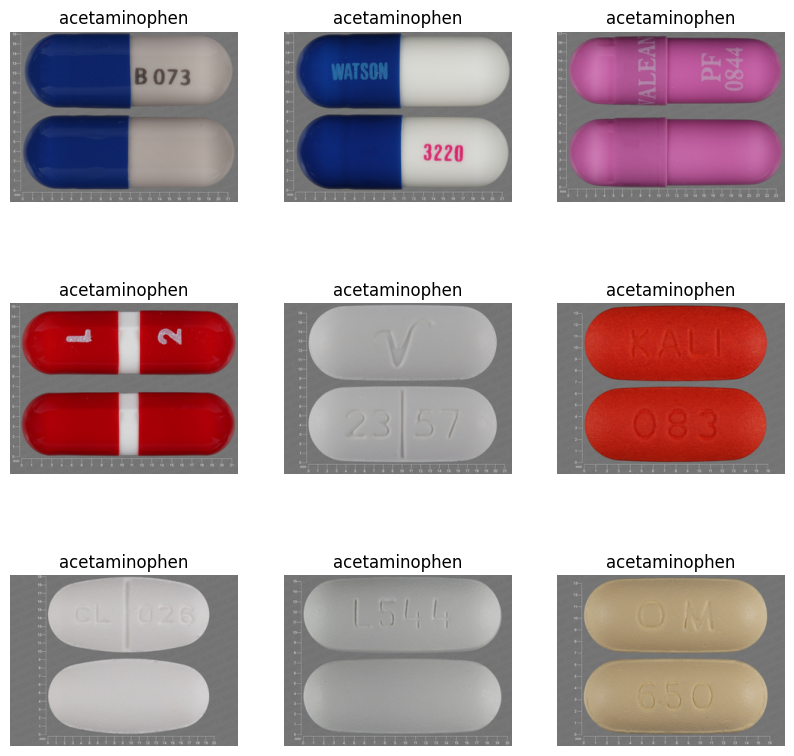

In [18]:
# print the first 5 image paths and decoded labels for the training dataset
for index, row in top20_instances_df.head(5).iterrows():
    image = row['image_paths']
    label = row['base_label']
    print("Image:", image)
    print("Label:", encoder.inverse_transform([label])[0])
    print()

# display the first 9 images and their labels
plt.figure(figsize=(10, 10))
for i, (index, row) in enumerate(top20_instances_df.head(9).iterrows()):
    image_path = os.path.join(training_dir, row['image_paths'])  # Append training_dir to the beginning of the path
    label = row['base_label']
    ax = plt.subplot(3, 3, i + 1)
    
    # Open the image file
    with Image.open(image_path) as img:
        plt.imshow(img)
    
    plt.title(encoder.inverse_transform([label])[0])
    plt.axis("off")

Image: PillProjectDisc102/images/SW6WWOIZYS_-KGZ06H56GRM0LU2JL0.JPG
Label: acetaminophen

Image: PillProjectDisc104/images/V58T12T8IVQZSDEAGXJRFTOPOOVBTZ.JPG
Label: acetaminophen

Image: PillProjectDisc109/images/ZHA8Q0SLMEH0NLD1HUJAONPJTQOULI.JPG
Label: acetaminophen

Image: PillProjectDisc19/images/B3!JMH4I72GCEFGHS!H3S3YX29X!T!6.JPG
Label: acetaminophen

Image: PillProjectDisc31/images/BEUNKANGYL35POW6SZX0CPP6UTWNT-W.JPG
Label: acetaminophen



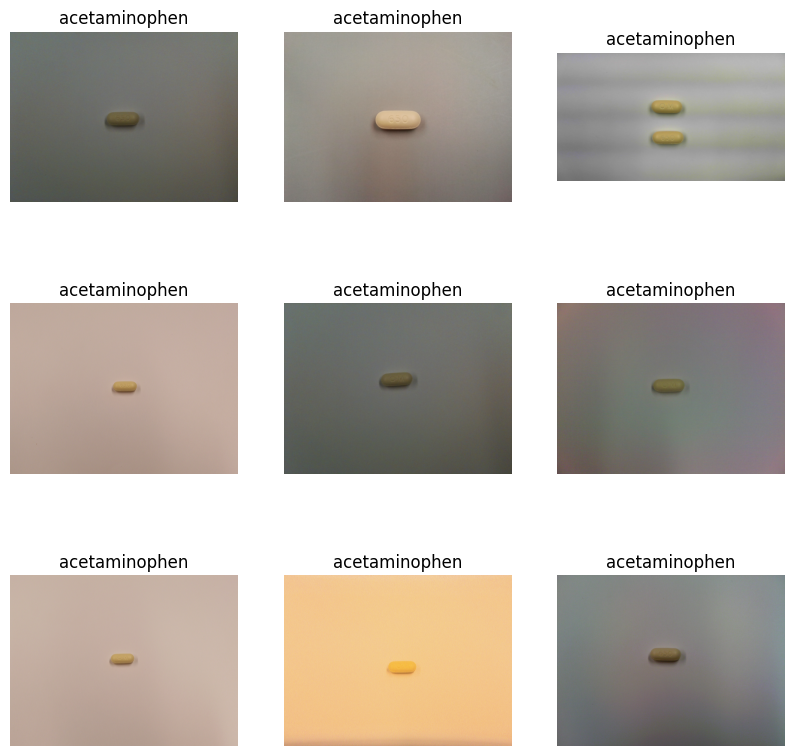

In [19]:
# print the first 5 image paths and decoded labels for the test dataset
for index, row in test_df.head(5).iterrows():
    image = row['image_paths']
    label = row['base_label']
    print("Image:", image)
    print("Label:", encoder.inverse_transform([label])[0])
    print()

# display the first 9 images and their labels
plt.figure(figsize=(10, 10))
for i, (index, row) in enumerate(test_df.head(9).iterrows()):
    image_file_name = os.path.basename(row['image_paths'])  
    image_path = os.path.join(test_dir, image_file_name)  
    label = row['base_label']
    ax = plt.subplot(3, 3, i + 1)
    
    # Open the image file
    with Image.open(image_path) as img:
        plt.imshow(img)
    
    plt.title(encoder.inverse_transform([label])[0])
    plt.axis("off")

# Data Augmentation

In [20]:
train_df = top20_instances_df

#Convert column into strings
top20_instances_df["image_paths"] = top20_instances_df["image_paths"].astype(str)
top20_instances_df["base_label"] = top20_instances_df["base_label"].astype(str)
test_df["image_paths"] = test_df["image_paths"].astype(str)
test_df["base_label"] = test_df["base_label"].astype(str)

# retrieve the base paths
test_df['image_paths'] = test_df['image_paths'].apply(os.path.basename)
train_df['image_paths'] = train_df['image_paths'].apply(os.path.basename)

test_df, eval_df = train_test_split(test_df, test_size=0.2, random_state=42)

Found 1338 validated image filenames belonging to 20 classes.
Found 803 validated image filenames belonging to 19 classes.
Found 3212 validated image filenames belonging to 20 classes.
Found 1 validated image filenames belonging to 1 classes.


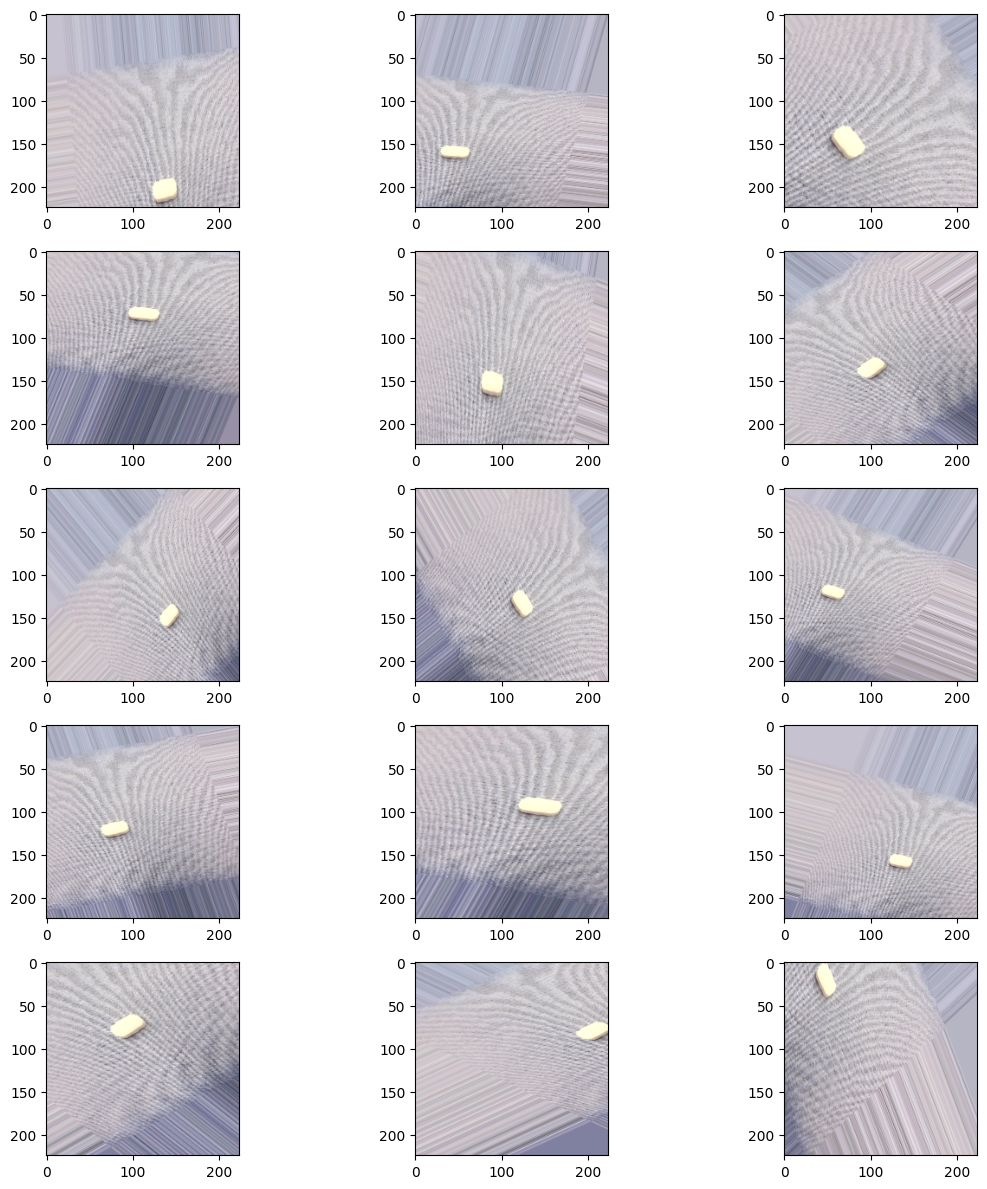

In [21]:
# Create the image data generator for the training set
imageTrain_data = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 60,
    shear_range = 0.3,
    zoom_range = 0.5,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    fill_mode="nearest",
)

train_generator = imageTrain_data.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    x_col = "image_paths",
    y_col = "base_label",
    class_mode="categorical",
)


# Create the image data generator for the evaluation set
imageEval_data = ImageDataGenerator(rescale = 1./255.)

eval_generator = imageEval_data.flow_from_dataframe(
    dataframe=eval_df,
    directory=test_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    x_col = "image_paths",
    y_col = "base_label",
    class_mode="categorical",
)


# Create the image data generator for the test set
imageTest_data = ImageDataGenerator(rescale = 1./255.)

test_generator = imageTest_data.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    x_col = "image_paths",
    y_col = "base_label",
    class_mode="categorical",
)

#Display example of image augmentation
sample_dataframe = test_df.sample(n=1).reset_index(drop=True)
sample_generator = imageTrain_data.flow_from_dataframe(
    dataframe=sample_dataframe,
    directory=test_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    x_col = "image_paths",
    y_col = "base_label",
    class_mode="categorical",
)

plt.figure(figsize=(12, 12))
for i in range (0, 15):
  ax = plt.subplot(5, 3, i + 1)
  for X_column, Y_column in sample_generator:
    plt.imshow(X_column[0])
    break
plt.tight_layout()
plt.show()

# Model Training

In [26]:
all_labels = pd.concat([train_df['base_label'], eval_df['base_label'], test_df['base_label']])
num_labels = all_labels.nunique()

In [37]:
# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ViTForImageClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # self.vit = ViTModel(config, add_pooling_layer=False)
        # self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.vit = ViTModel(config, add_pooling_layer=False).to(device)                # Move model to Nvidia card
        self.classifier = nn.Linear(config.hidden_size, config.num_labels).to(device)  # Move model to Nvidia card

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        logits = self.classifier(outputs.last_hidden_state[:, 0])
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
    

# compute accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    if isinstance(labels, int):
        labels = [labels]
    accuracy = load_metric("accuracy").compute(predictions=predictions, references=labels)
    print(f"Accuracy: {accuracy}")
    return accuracy
    
        
# create feature extractor to tokenize data
feature_extractor = ViTImageProcessor(
    image_size=224,
    do_resize=True,
    do_normalize=True,
    do_rescale=False,
    image_mean=[0.5, 0.5, 0.5],
    image_std=[0.5, 0.5, 0.5],
)


# Define a function to load and preprocess the images
def load_and_preprocess_images(example, directory):
    # Load the image from the file
    image = Image.open(directory + example['image_paths'])
    image = np.array(image, dtype=np.uint8)
    image = np.moveaxis(image, source=-1, destination=0)
    # Preprocess the image
    inputs = feature_extractor(images=[image])
    pixel_values = torch.tensor(inputs['pixel_values'][0], dtype=torch.float32).to(device)  # convert to tensor and move to device
    label = int(example['labels'])
    return {'pixel_values': pixel_values, 'labels': label}


# define a custom data collator
def data_collator(features):
    pixel_values = [torch.tensor(feature['pixel_values'], dtype=torch.float32).to(device) for feature in features]  # Move to device
    labels = [feature['labels'] for feature in features]
    pixel_values = torch.stack(pixel_values)
    return {'pixel_values': pixel_values, 'labels': torch.tensor(labels).to(device)}  # Move to device


# Define the features of the dataset
features = Features({
    'labels': ClassLabel(num_classes=num_labels),
    'img': Array3D(dtype="int64", shape=(3, 32, 32)),
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
})

# Generate lists of image paths and labels for training dataset
train_image_paths = train_df["image_paths"].tolist()
train_labels = train_df["base_label"].tolist()

# Create a dictionary with the image paths and labels
train_dict = {'image_paths': train_image_paths, 'labels': train_labels}

# Create the dataset
train_dataset = Dataset.from_dict(train_dict)

# Apply the function to the dataset
train_dataset = train_dataset.map(lambda example: load_and_preprocess_images(example, 'training20_set/'))
train_dataset = train_dataset.remove_columns(['image_paths'])


# Repeat the same process for the evaluation and test datasets
eval_image_paths = eval_df["image_paths"].tolist()
eval_labels = eval_df["base_label"].tolist()
eval_dict = {'image_paths': eval_image_paths, 'labels': eval_labels}
eval_dataset = Dataset.from_dict(eval_dict)
eval_dataset = eval_dataset.map(lambda example: load_and_preprocess_images(example, 'testing20_set/'))
eval_dataset = eval_dataset.remove_columns(['image_paths'])


test_image_paths = test_df["image_paths"].tolist()
test_labels = test_df["base_label"].tolist()
test_dict = {'image_paths': test_image_paths, 'labels': test_labels}
test_dataset = Dataset.from_dict(test_dict)
test_dataset = test_dataset.map(lambda example: load_and_preprocess_images(example, 'testing20_set/'))
test_dataset = test_dataset.remove_columns(['image_paths'])


# Load the pre-trained model
pretrained_model = ViTModel.from_pretrained('google/vit-base-patch16-224')

# Define your custom model
config = pretrained_model.config
config.num_labels = num_labels
model = ViTForImageClassification(config)

# Copy the pre-trained weights to your custom model
model.vit = pretrained_model

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of evaluations with no improvement after which training will be stopped.
    early_stopping_threshold=0.0  # Threshold for measuring the new optimum, to only focus on significant changes.
)

# create the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=75,                # number of warmup steps for learning rate scheduler
    weight_decay=0.018,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    logging_first_step=True,
    logging_strategy='steps',
    evaluation_strategy='epoch',
    eval_steps=10,  
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    learning_rate=3e-5,
    gradient_accumulation_steps=1,      # prevents vanishing/exploding gradients
    max_grad_norm=1.0,                  # prevents vanishing/exploding gradients
    # fp16=True                     # mixed precision training; enable if using nVidia graphics cards
)

class CustomTrainer(Trainer):
    def get_train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.args.train_batch_size, shuffle=True, collate_fn=self.data_collator)
    
    def compute_loss(self, model, inputs, return_outputs=False):
        # Move inputs to device
        for key, value in inputs.items():
            inputs[key] = value.to(device)

        outputs = model(**inputs)
        logits = outputs.logits

        labels = inputs["labels"]  # Get labels from inputs

        loss = torch.nn.functional.cross_entropy(logits, labels)
        return (loss, outputs) if return_outputs else loss
        
mainTrainer = CustomTrainer (
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]  # Add the early stopping callback
)

Map:   0%|          | 0/1338 [00:00<?, ? examples/s]

Map:   0%|          | 0/803 [00:00<?, ? examples/s]

Map:   0%|          | 0/3212 [00:00<?, ? examples/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
mainTrainer.train()
mainTrainer.save_model('./saved_model')

  0%|          | 0/840 [00:00<?, ?it/s]

{'loss': 3.0364, 'learning_rate': 4.0000000000000003e-07, 'epoch': 0.01}
{'loss': 3.0278, 'learning_rate': 4e-06, 'epoch': 0.12}
{'loss': 2.94, 'learning_rate': 8e-06, 'epoch': 0.24}
{'loss': 2.7714, 'learning_rate': 1.2e-05, 'epoch': 0.36}
{'loss': 2.8482, 'learning_rate': 1.6e-05, 'epoch': 0.48}
{'loss': 2.8158, 'learning_rate': 1.9999999999999998e-05, 'epoch': 0.6}
{'loss': 2.7292, 'learning_rate': 2.4e-05, 'epoch': 0.71}
{'loss': 2.9095, 'learning_rate': 2.8e-05, 'epoch': 0.83}
{'loss': 2.784, 'learning_rate': 2.9803921568627453e-05, 'epoch': 0.95}


  0%|          | 0/51 [00:00<?, ?it/s]

C:\Users\jong\AppData\Local\Temp\ipykernel_23844\2040511853.py:34: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy = load_metric("accuracy").compute(predictions=predictions, references=labels)
C:\Users\jong\AppData\Roaming\Python\Python311\site-packages\datasets\load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Accuracy: {'accuracy': 0.1320049813200498}
{'eval_loss': 2.767674446105957, 'eval_accuracy': 0.1320049813200498, 'eval_runtime': 122.0926, 'eval_samples_per_second': 6.577, 'eval_steps_per_second': 0.418, 'epoch': 1.0}
{'loss': 2.6681, 'learning_rate': 2.9411764705882354e-05, 'epoch': 1.07}
{'loss': 2.6169, 'learning_rate': 2.9019607843137255e-05, 'epoch': 1.19}
{'loss': 2.5404, 'learning_rate': 2.862745098039216e-05, 'epoch': 1.31}
{'loss': 2.5812, 'learning_rate': 2.823529411764706e-05, 'epoch': 1.43}
{'loss': 2.5892, 'learning_rate': 2.7843137254901964e-05, 'epoch': 1.55}
{'loss': 2.4302, 'learning_rate': 2.745098039215686e-05, 'epoch': 1.67}
{'loss': 2.4014, 'learning_rate': 2.7058823529411766e-05, 'epoch': 1.79}
{'loss': 2.2946, 'learning_rate': 2.6666666666666667e-05, 'epoch': 1.9}


  0%|          | 0/51 [00:00<?, ?it/s]

C:\Users\jong\AppData\Roaming\Python\Python311\site-packages\datasets\load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Accuracy: {'accuracy': 0.1656288916562889}
{'eval_loss': 2.807738780975342, 'eval_accuracy': 0.1656288916562889, 'eval_runtime': 120.4072, 'eval_samples_per_second': 6.669, 'eval_steps_per_second': 0.424, 'epoch': 2.0}
{'loss': 2.2731, 'learning_rate': 2.627450980392157e-05, 'epoch': 2.02}
{'loss': 2.2144, 'learning_rate': 2.5882352941176472e-05, 'epoch': 2.14}
{'loss': 2.1363, 'learning_rate': 2.5490196078431373e-05, 'epoch': 2.26}
{'loss': 2.3437, 'learning_rate': 2.5098039215686277e-05, 'epoch': 2.38}
{'loss': 2.0889, 'learning_rate': 2.4705882352941174e-05, 'epoch': 2.5}
{'loss': 2.0526, 'learning_rate': 2.431372549019608e-05, 'epoch': 2.62}
{'loss': 2.1101, 'learning_rate': 2.3921568627450983e-05, 'epoch': 2.74}
{'loss': 2.0657, 'learning_rate': 2.3529411764705884e-05, 'epoch': 2.86}
{'loss': 1.9463, 'learning_rate': 2.3137254901960785e-05, 'epoch': 2.98}


  0%|          | 0/51 [00:00<?, ?it/s]

C:\Users\jong\AppData\Roaming\Python\Python311\site-packages\datasets\load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Accuracy: {'accuracy': 0.1519302615193026}
{'eval_loss': 2.979262351989746, 'eval_accuracy': 0.1519302615193026, 'eval_runtime': 120.7818, 'eval_samples_per_second': 6.648, 'eval_steps_per_second': 0.422, 'epoch': 3.0}
{'loss': 1.9239, 'learning_rate': 2.2745098039215685e-05, 'epoch': 3.1}
{'loss': 1.8272, 'learning_rate': 2.235294117647059e-05, 'epoch': 3.21}
{'loss': 1.8095, 'learning_rate': 2.196078431372549e-05, 'epoch': 3.33}
{'loss': 1.9546, 'learning_rate': 2.156862745098039e-05, 'epoch': 3.45}
{'loss': 1.7842, 'learning_rate': 2.1176470588235296e-05, 'epoch': 3.57}
{'loss': 1.7574, 'learning_rate': 2.0784313725490197e-05, 'epoch': 3.69}
{'loss': 1.6508, 'learning_rate': 2.03921568627451e-05, 'epoch': 3.81}
{'loss': 1.7389, 'learning_rate': 1.9999999999999998e-05, 'epoch': 3.93}


  0%|          | 0/51 [00:00<?, ?it/s]

C:\Users\jong\AppData\Roaming\Python\Python311\site-packages\datasets\load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Accuracy: {'accuracy': 0.16811955168119552}
{'eval_loss': 3.015150308609009, 'eval_accuracy': 0.16811955168119552, 'eval_runtime': 121.7845, 'eval_samples_per_second': 6.594, 'eval_steps_per_second': 0.419, 'epoch': 4.0}
{'loss': 1.6002, 'learning_rate': 1.9607843137254903e-05, 'epoch': 4.05}
{'loss': 1.5767, 'learning_rate': 1.9215686274509803e-05, 'epoch': 4.17}
{'loss': 1.6084, 'learning_rate': 1.8823529411764708e-05, 'epoch': 4.29}
{'loss': 1.517, 'learning_rate': 1.843137254901961e-05, 'epoch': 4.4}
{'loss': 1.6278, 'learning_rate': 1.803921568627451e-05, 'epoch': 4.52}
{'loss': 1.4554, 'learning_rate': 1.7647058823529414e-05, 'epoch': 4.64}
{'loss': 1.5184, 'learning_rate': 1.7254901960784314e-05, 'epoch': 4.76}
{'loss': 1.4267, 'learning_rate': 1.6862745098039215e-05, 'epoch': 4.88}
{'loss': 1.4943, 'learning_rate': 1.647058823529412e-05, 'epoch': 5.0}


  0%|          | 0/51 [00:00<?, ?it/s]

C:\Users\jong\AppData\Roaming\Python\Python311\site-packages\datasets\load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Accuracy: {'accuracy': 0.1519302615193026}
{'eval_loss': 3.121670722961426, 'eval_accuracy': 0.1519302615193026, 'eval_runtime': 120.4782, 'eval_samples_per_second': 6.665, 'eval_steps_per_second': 0.423, 'epoch': 5.0}
{'loss': 1.4359, 'learning_rate': 1.607843137254902e-05, 'epoch': 5.12}
{'loss': 1.4736, 'learning_rate': 1.568627450980392e-05, 'epoch': 5.24}
{'loss': 1.253, 'learning_rate': 1.5294117647058822e-05, 'epoch': 5.36}
{'loss': 1.2109, 'learning_rate': 1.4901960784313726e-05, 'epoch': 5.48}
{'loss': 1.351, 'learning_rate': 1.4509803921568627e-05, 'epoch': 5.6}
{'loss': 1.3427, 'learning_rate': 1.411764705882353e-05, 'epoch': 5.71}
{'loss': 1.3233, 'learning_rate': 1.372549019607843e-05, 'epoch': 5.83}
{'loss': 1.2933, 'learning_rate': 1.3333333333333333e-05, 'epoch': 5.95}


  0%|          | 0/51 [00:00<?, ?it/s]

C:\Users\jong\AppData\Roaming\Python\Python311\site-packages\datasets\load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Accuracy: {'accuracy': 0.15442092154420922}
{'eval_loss': 3.0678679943084717, 'eval_accuracy': 0.15442092154420922, 'eval_runtime': 121.6015, 'eval_samples_per_second': 6.604, 'eval_steps_per_second': 0.419, 'epoch': 6.0}
{'loss': 1.1903, 'learning_rate': 1.2941176470588236e-05, 'epoch': 6.07}
{'loss': 1.1758, 'learning_rate': 1.2549019607843138e-05, 'epoch': 6.19}
{'loss': 1.2174, 'learning_rate': 1.215686274509804e-05, 'epoch': 6.31}
{'loss': 1.0706, 'learning_rate': 1.1764705882352942e-05, 'epoch': 6.43}
{'loss': 1.2455, 'learning_rate': 1.1372549019607843e-05, 'epoch': 6.55}
{'loss': 1.1305, 'learning_rate': 1.0980392156862745e-05, 'epoch': 6.67}
{'loss': 1.0489, 'learning_rate': 1.0588235294117648e-05, 'epoch': 6.79}
{'loss': 1.2113, 'learning_rate': 1.019607843137255e-05, 'epoch': 6.9}


  0%|          | 0/51 [00:00<?, ?it/s]

C:\Users\jong\AppData\Roaming\Python\Python311\site-packages\datasets\load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Accuracy: {'accuracy': 0.15442092154420922}
{'eval_loss': 3.1105480194091797, 'eval_accuracy': 0.15442092154420922, 'eval_runtime': 132.4557, 'eval_samples_per_second': 6.062, 'eval_steps_per_second': 0.385, 'epoch': 7.0}
{'loss': 1.0869, 'learning_rate': 9.803921568627451e-06, 'epoch': 7.02}
{'loss': 0.9935, 'learning_rate': 9.411764705882354e-06, 'epoch': 7.14}
{'loss': 1.1141, 'learning_rate': 9.019607843137255e-06, 'epoch': 7.26}
{'loss': 0.9594, 'learning_rate': 8.627450980392157e-06, 'epoch': 7.38}
{'loss': 1.0019, 'learning_rate': 8.23529411764706e-06, 'epoch': 7.5}
{'loss': 1.0681, 'learning_rate': 7.84313725490196e-06, 'epoch': 7.62}
{'loss': 1.0499, 'learning_rate': 7.450980392156863e-06, 'epoch': 7.74}
{'loss': 1.0697, 'learning_rate': 7.058823529411765e-06, 'epoch': 7.86}
{'loss': 0.9852, 'learning_rate': 6.666666666666667e-06, 'epoch': 7.98}


  0%|          | 0/51 [00:00<?, ?it/s]

C:\Users\jong\AppData\Roaming\Python\Python311\site-packages\datasets\load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Accuracy: {'accuracy': 0.1506849315068493}
{'eval_loss': 3.096756935119629, 'eval_accuracy': 0.1506849315068493, 'eval_runtime': 134.4298, 'eval_samples_per_second': 5.973, 'eval_steps_per_second': 0.379, 'epoch': 8.0}
{'loss': 1.0103, 'learning_rate': 6.274509803921569e-06, 'epoch': 8.1}
{'loss': 0.9189, 'learning_rate': 5.882352941176471e-06, 'epoch': 8.21}
{'loss': 0.9025, 'learning_rate': 5.490196078431373e-06, 'epoch': 8.33}
{'loss': 0.8823, 'learning_rate': 5.098039215686275e-06, 'epoch': 8.45}
{'loss': 0.9801, 'learning_rate': 4.705882352941177e-06, 'epoch': 8.57}
{'loss': 0.8613, 'learning_rate': 4.313725490196079e-06, 'epoch': 8.69}
{'loss': 0.9245, 'learning_rate': 3.92156862745098e-06, 'epoch': 8.81}
{'loss': 0.8396, 'learning_rate': 3.5294117647058825e-06, 'epoch': 8.93}


  0%|          | 0/51 [00:00<?, ?it/s]

C:\Users\jong\AppData\Roaming\Python\Python311\site-packages\datasets\load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Accuracy: {'accuracy': 0.14570361145703611}
{'eval_loss': 3.110544204711914, 'eval_accuracy': 0.14570361145703611, 'eval_runtime': 135.4202, 'eval_samples_per_second': 5.93, 'eval_steps_per_second': 0.377, 'epoch': 9.0}
{'loss': 1.0605, 'learning_rate': 3.1372549019607846e-06, 'epoch': 9.05}
{'loss': 0.7804, 'learning_rate': 2.7450980392156863e-06, 'epoch': 9.17}
{'loss': 0.8165, 'learning_rate': 2.3529411764705885e-06, 'epoch': 9.29}
{'loss': 0.9112, 'learning_rate': 1.96078431372549e-06, 'epoch': 9.4}
{'loss': 0.8548, 'learning_rate': 1.5686274509803923e-06, 'epoch': 9.52}
{'loss': 0.8161, 'learning_rate': 1.1764705882352942e-06, 'epoch': 9.64}
{'loss': 0.8099, 'learning_rate': 7.843137254901962e-07, 'epoch': 9.76}
{'loss': 0.8523, 'learning_rate': 3.921568627450981e-07, 'epoch': 9.88}
{'loss': 0.8991, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/51 [00:00<?, ?it/s]

C:\Users\jong\AppData\Roaming\Python\Python311\site-packages\datasets\load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Accuracy: {'accuracy': 0.15442092154420922}
{'eval_loss': 3.138807535171509, 'eval_accuracy': 0.15442092154420922, 'eval_runtime': 130.6087, 'eval_samples_per_second': 6.148, 'eval_steps_per_second': 0.39, 'epoch': 10.0}
{'train_runtime': 6150.7226, 'train_samples_per_second': 2.175, 'train_steps_per_second': 0.137, 'train_loss': 1.6056511302789052, 'epoch': 10.0}
